# Rong Huang
## USCID: 6857552986

In [1]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from tqdm import tqdm
random.seed(1000)


import warnings
warnings.filterwarnings('ignore')

import graphviz as gr
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
style.use("fivethirtyeight")

In [2]:
def fn_variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)
# Note this is equivalent to np.var(Yt,ddof)

In [3]:
def fn_generate_cov(dim):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

def fn_generate_multnorm(nobs,corr,nvar):
    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

#     return (Y,np.round(np.corrcoef(Y,rowvar=False),2))
    return Y

def fn_randomize_treatment(N,p=0.5):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])

In [4]:
def fn_generate_data(tau,N,p,p0,corr,conf = True,flagX = False):
    """
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal

    if conf==False:
        conf_mult = 0 # remove confounder from outcome
    else:
        conf_mult = 1
        
    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates
    
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+conf_mult*0.6*C+err #outcome equation
    if flagX==False:
        return (Yab,T)
    else:
        return (Yab,T,X)
    
    # regression discontinuity
#     W = W0 + 0.5*C+3*X[:,80].reshape([N,1])-6*X[:,81].reshape([N,1])
#     treated = 1*(W>0)
#     Yrdd = 1.2* treated - 4*W + X@beta0 +0.6*C+err

def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value
    thetatahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    """
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)

def fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX=False):
    '''
    tau - treatment effet
    Nrange - range of sample sizes
    p - number of covariates genrated
    p0 - number of covariates included
    corr - correlation between covariates
    conf - confounder
    '''
    n_values = []
    tauhats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        if flagX==False:
            #"No X's included"
            Yexp,T = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Yt = Yexp[np.where(T==1)[0],:]
            Yc = Yexp[np.where(T==0)[0],:]
            tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)            
        elif flagX==1:
            # use the right covariates in regression
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
        elif flagX==2:
            # use some of the right covariates and some "wrong" ones
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs1 = X[:,:np.int(p0/2)]
            Xobs2 = X[:,-np.int(p0/2):]
            covars = np.concatenate([T,Xobs1,Xobs2],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
            
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]    
        lb = lb + [tauhat-1.96*se_tauhat]
        ub = ub + [tauhat+1.96*se_tauhat]
        
    return (n_values,tauhats,sehats,lb,ub)


def fn_plot_with_ci(n_values,tauhats,tau,lb,ub,caption):
    fig = plt.figure(figsize = (10,6))
    #plots x against y
    #the label is what comes out in the legend
    plt.plot(n_values,tauhats,label = '$\hat{\\tau}$')
    plt.xlabel('N')
    plt.ylabel('$\hat{\\tau}$')
    #axhline is a horizontal line at the true value of tau
    plt.axhline(y=tau, color='r', linestyle='-',linewidth=1,
                label='True $\\tau$={}'.format(tau))
    plt.title('{}'.format(caption))
    #fill confidence interval
    #alpha is the opacity of the fill
    plt.fill_between(n_values, lb, ub,
        alpha=0.5, edgecolor='#FF9848', facecolor='#FF9848',label = '95% CI')
    plt.legend()

In [5]:
import networkx as nx
graph = nx.DiGraph()
graph = nx.Graph()
graph.add_edges_from([('x', 'y'), ('y', 'z')])
nx.is_directed(graph) # => False
nx.is_directed_acyclic_graph(graph) # => False
from matplotlib import pyplot as plt
g1 = nx.DiGraph()
g1.add_edges_from([("root", "a"), ("a", "b"), ("a", "e"), ("b", "c"), ("b", "d"), ("d", "e")])
plt.tight_layout()
nx.draw_networkx(g1, arrows=True)
plt.savefig("g1.png", format="PNG")
# tell matplotlib you're done with the plot: https://stackoverflow.com/questions/741877/how-do-i-tell-matplotlib-that-i-am-done-with-a-plot
plt.clf()
g2 = nx.DiGraph()
g2.add_edges_from([(1, 2), (2, 3), (3, 4), (4, 1)])
plt.tight_layout()
nx.draw_networkx(g2, arrows=True)
plt.savefig("g2.png", format="PNG")
plt.clf()

<Figure size 432x288 with 0 Axes>

# Part 1
## (a) not control for any covariates
$y_i = \tau*T_i+e_i$

### Simulate a DGP

100%|█████████████████████████████████████████| 495/495 [00:05<00:00, 86.35it/s]


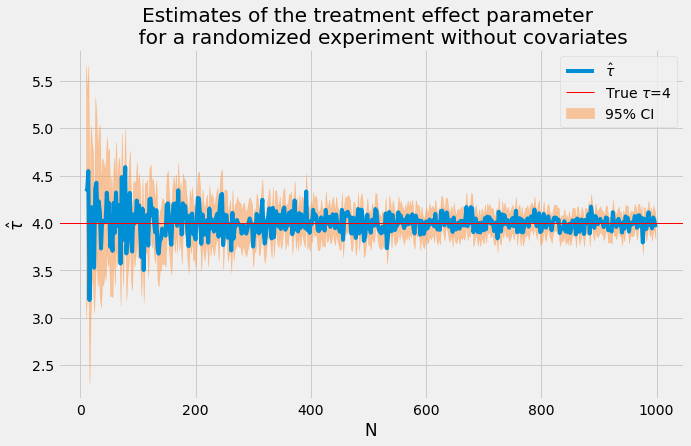

In [6]:
random.seed(10)
tau = 4
corr = .7
conf=False
p = 100
p0 = 0 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
(nvalues_1a,tauhats_1a,sehats_1a,lb,ub) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)
caption_1a = """Estimates of the treatment effect parameter 
    for a randomized experiment without covariates"""
fn_plot_with_ci(nvalues_1a,tauhats_1a,tau,lb,ub,caption_1a)

### Illustrate DAG with real-life situation

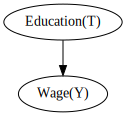

In [7]:
g1a = gr.Digraph()
g1a.edge("Education(T)", "Wage(Y)")

g1a

### Using a Monte Carlo experiment with sample size N = 100

In [8]:
N = 100
Yexp,T = fn_generate_data(tau,N,100,0,corr,conf = False)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
# n_values = n_values + [N]
# tauhats = tauhats + [tauhat]
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]
tauhat,se_tauhat

(3.839521326307639, 0.21537107626225233)

In [9]:
# np.linalg.inv(np.transpose(T)@T)@np.transpose(T)@Yexp
const = np.ones([N,1])
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
# res.summary()
res.params[0], res.HC1_se[0]

(3.839521326307639, 0.21537107626225233)

### Using a Monte Carlo experiment with sample size N = 1000

In [10]:
N = 1000
Yexp,T = fn_generate_data(tau,N,100,0,corr,conf = False)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
# n_values = n_values + [N]
# tauhats = tauhats + [tauhat]
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]
tauhat,se_tauhat

(3.9962043099751132, 0.06343606285180288)

In [11]:
# np.linalg.inv(np.transpose(T)@T)@np.transpose(T)@Yexp
const = np.ones([N,1])
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
# res.summary()
res.params[0], res.HC1_se[0]

(3.9962043099751137, 0.06343606285180292)

### Run R Monte Carlo iterations and compute bias, RMSE and size

In [12]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,100,0,corr,conf = False)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])}

100%|███████████████████████████████████████| 2000/2000 [00:42<00:00, 47.49it/s]


test null that $\tau = \tau_0$

In [13]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}') 

N=100: bias=0.0048681009767075805, RMSE=0.20030483917087252, size=0.0535
N=1000: bias=-0.0039594791259168725, RMSE=0.0630090864849141, size=0.052


# Part 1
## (b) control for all the covariates that affect the outcome
$y_i = \tau*T_i+\beta'*x_i+e_i$

### Simulate a DGP

100%|█████████████████████████████████████████| 495/495 [00:08<00:00, 61.73it/s]


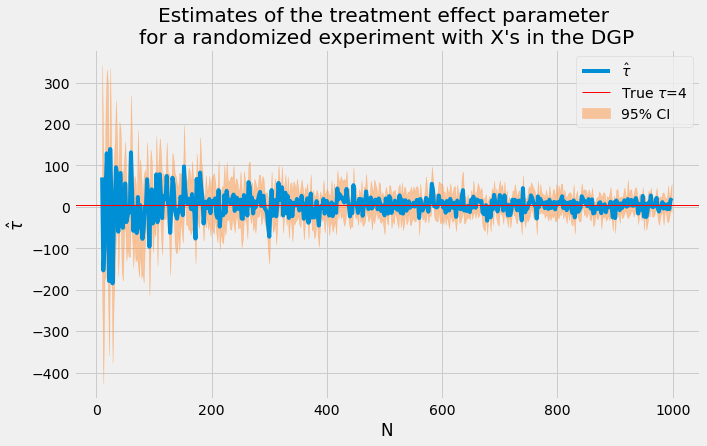

In [14]:
tau = 4
corr = .7
conf = False
p = 100
p0 = 50 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
(nvalues_1b,tauhats_1b,sehats_1b,lb,ub) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)
caption_1b = """Estimates of the treatment effect parameter 
for a randomized experiment with X's in the DGP"""
fn_plot_with_ci(nvalues_1b,tauhats_1b,tau,lb,ub,caption_1b)

### Illustrate DAG with real-life situation

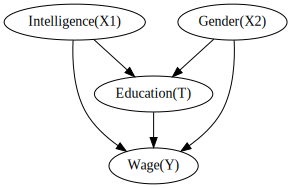

In [15]:
g1b = gr.Digraph()
g1b.edge("Education(T)", "Wage(Y)")
g1b.edge("Intelligence(X1)", "Wage(Y)")
g1b.edge("Gender(X2)", "Wage(Y)")
g1b.edge("Intelligence(X1)", "Education(T)")
g1b.edge("Gender(X2)", "Education(T)")

g1b

### Using a Monte Carlo experiment with sample size N = 100

In [32]:
N = 100
Yexp,T = fn_generate_data(tau,N,100,50,corr,conf = False)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
# n_values = n_values + [N]
# tauhats = tauhats + [tauhat]
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]
tauhat,se_tauhat

(40.27829657704959, 57.61483527890321)

In [33]:
# np.linalg.inv(np.transpose(T)@T)@np.transpose(T)@Yexp
const = np.ones([N,1])
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
# res.summary()
res.params[0], res.HC1_se[0]

(40.278296577049574, 57.6148352789032)

### Using a Monte Carlo experiment with sample size N = 1000

In [34]:
N = 1000
Yexp,T = fn_generate_data(tau,N,100,50,corr,conf = False)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
# n_values = n_values + [N]
# tauhats = tauhats + [tauhat]
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]
tauhat,se_tauhat

(6.912375362933467, 17.13268523376888)

In [35]:
# np.linalg.inv(np.transpose(T)@T)@np.transpose(T)@Yexp
const = np.ones([N,1])
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
# res.summary()
res.params[0], res.HC1_se[0]

(6.912375362933468, 17.13268523376888)

### Run R Monte Carlo iterations and compute bias, RMSE and size

In [36]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,100,50,corr,conf=False)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])}

100%|███████████████████████████████████████| 2000/2000 [00:36<00:00, 54.22it/s]


test null that $\tau = \tau_0$

In [37]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.5816746808133073, RMSE=43.63746554939634, size=0.0595
N=1000: bias=-0.022004736979080064, RMSE=13.629575495373594, size=0.0505


The treatment effect parameter (tau) that we control for all the covariates that affect the outcome is larger than the treatment effect parameter (tau) that we do not control for any covariates.

# Part 2
## (a) fail to control for the confounder
$y_i = \tau*T_i+\beta'*x_i+e_i$

### Simulate a DGP

100%|█████████████████████████████████████████| 495/495 [00:05<00:00, 85.25it/s]


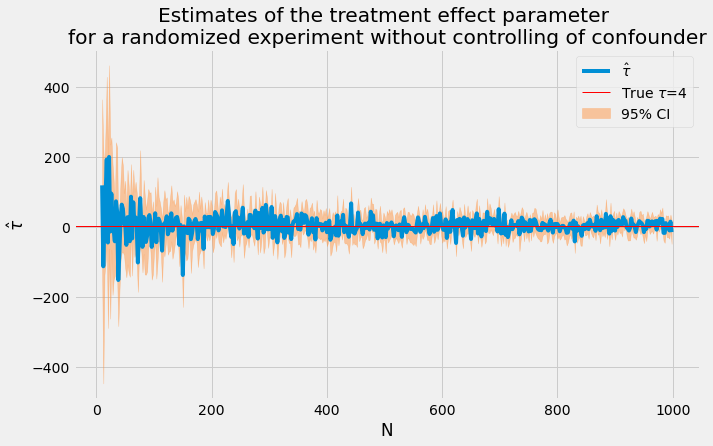

In [22]:
tau = 4
corr = .7
conf = False
p = 100
p0 = 50 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
(nvalues_2a,tauhats_2a,sehats_2a,lb,ub) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)
caption_2a = """Estimates of the treatment effect parameter 
for a randomized experiment without controlling of confounder"""
fn_plot_with_ci(nvalues_2a,tauhats_2a,tau,lb,ub,caption_2a)

### Illustrate DAG with real-life situation

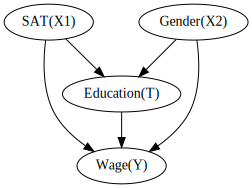

In [23]:
g2a = gr.Digraph()
g2a.edge("Education(T)", "Wage(Y)")
g2a.edge("SAT(X1)", "Wage(Y)")
g2a.edge("Gender(X2)", "Wage(Y)")
g2a.edge("SAT(X1)", "Education(T)")
g2a.edge("Gender(X2)", "Education(T)")

g2a

### Using a Monte Carlo experiment with sample size N = 100

In [24]:
N = 100
Yexp,T = fn_generate_data(tau,N,100,50,corr,conf = False)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
# n_values = n_values + [N]
# tauhats = tauhats + [tauhat]
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]
tauhat,se_tauhat

(-23.92392415640017, 57.87742947576937)

In [25]:
# np.linalg.inv(np.transpose(T)@T)@np.transpose(T)@Yexp
const = np.ones([N,1])
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
# res.summary()
res.params[0], res.HC1_se[0]

(-23.923924156400172, 57.877429475769375)

### Using a Monte Carlo experiment with sample size N = 1000

In [26]:
N = 1000
Yexp,T = fn_generate_data(tau,N,100,50,corr,conf = False)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
# n_values = n_values + [N]
# tauhats = tauhats + [tauhat]
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]
tauhat,se_tauhat

(-0.06815278390623902, 17.842316647609135)

In [27]:
# np.linalg.inv(np.transpose(T)@T)@np.transpose(T)@Yexp
const = np.ones([N,1])
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
# res.summary()
res.params[0], res.HC1_se[0]

(-0.06815278390624835, 17.842316647609135)

### Run R Monte Carlo iterations and compute bias, RMSE and size

In [41]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,100,50,corr,conf=False)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])}

100%|███████████████████████████████████████| 2000/2000 [00:40<00:00, 48.98it/s]


test null that $\tau = \tau_0$

In [42]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=1.6731965242011273, RMSE=43.023081905389496, size=0.0545
N=1000: bias=0.16331449980277177, RMSE=13.84068690102725, size=0.0545


# Part 2
## (b) control for the confounder
$y_i = \tau*T_i+\beta'*x_i+\gamma*U_i+e_i$

### Simulate a DGP

100%|█████████████████████████████████████████| 495/495 [00:07<00:00, 70.11it/s]


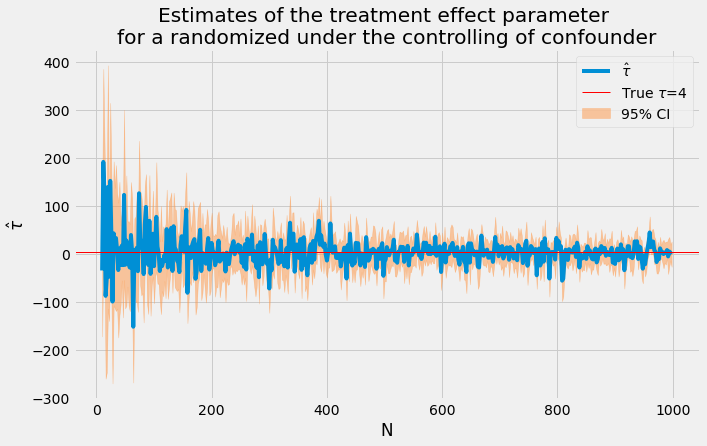

In [43]:
tau = 4
corr = .7
conf = True
p = 100
p0 = 50 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
(nvalues_2b,tauhats_2b,sehats_2b,lb,ub) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)
caption_2b = """Estimates of the treatment effect parameter 
for a randomized under the controlling of confounder"""
fn_plot_with_ci(nvalues_2b,tauhats_2b,tau,lb,ub,caption_2b)

### Illustrate DAG with real-life situation

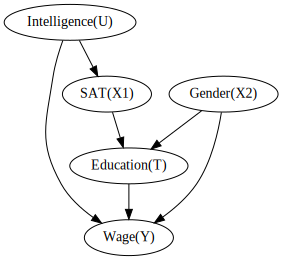

In [44]:
g2b = gr.Digraph()
g2b.edge("Education(T)", "Wage(Y)")
g2b.edge("Intelligence(U)", "Wage(Y)")
g2b.edge("Intelligence(U)", "SAT(X1)")
g2b.edge("Gender(X2)", "Wage(Y)")
g2b.edge("SAT(X1)", "Education(T)")
g2b.edge("Gender(X2)", "Education(T)")

g2b

### Using a Monte Carlo experiment with sample size N = 100

In [45]:
N = 100
Yexp,T = fn_generate_data(tau,N,100,50,corr,conf = True)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
# n_values = n_values + [N]
# tauhats = tauhats + [tauhat]
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]
tauhat,se_tauhat

(20.964067028693037, 49.269324055319785)

In [46]:
# np.linalg.inv(np.transpose(T)@T)@np.transpose(T)@Yexp
const = np.ones([N,1])
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
# res.summary()
res.params[0], res.HC1_se[0]

(20.96406702869306, 49.269324055319785)

### Using a Monte Carlo experiment with sample size N = 1000

In [47]:
N = 1000
Yexp,T = fn_generate_data(tau,N,100,50,corr,conf = True)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
# n_values = n_values + [N]
# tauhats = tauhats + [tauhat]
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]
tauhat,se_tauhat

(-4.86850356318665, 11.964555581765472)

In [48]:
# np.linalg.inv(np.transpose(T)@T)@np.transpose(T)@Yexp
const = np.ones([N,1])
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
# res.summary()
res.params[0], res.HC1_se[0]

(-4.868503563186648, 11.96455558176547)

### Run R Monte Carlo iterations and compute bias, RMSE and size

In [49]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,100,50,corr,conf=True)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])}

100%|███████████████████████████████████████| 2000/2000 [00:41<00:00, 48.02it/s]


test null that $\tau = \tau_0$

In [50]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.9936023832118553, RMSE=41.4811026095716, size=0.0495
N=1000: bias=0.017171670510838028, RMSE=13.611162182134173, size=0.0505


# Part 3
## (a) without selection bias

### Simulate a DGP

100%|█████████████████████████████████████████| 495/495 [00:08<00:00, 55.64it/s]


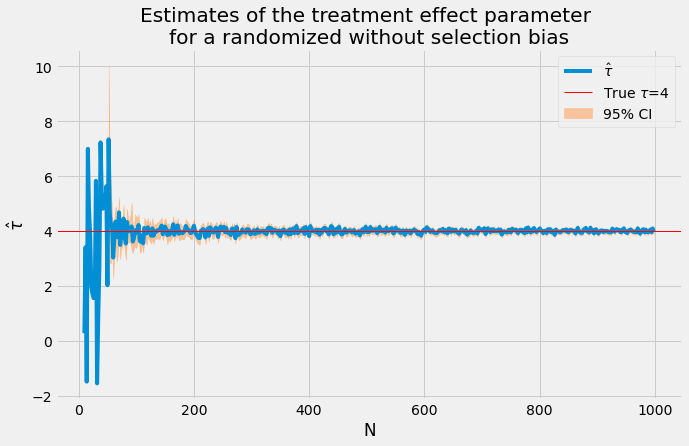

In [51]:
tau = 4
corr = .7
conf = True
p = 100
p0 = 50 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
flagX=1
(nvalues_3a,tauhats_3a,sehats_3a,lb,ub) = fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX)
caption_3a = """Estimates of the treatment effect parameter 
for a randomized without selection bias"""
fn_plot_with_ci(nvalues_3a,tauhats_3a,tau,lb,ub,caption_3a)


### Illustrate DAG with real-life situation

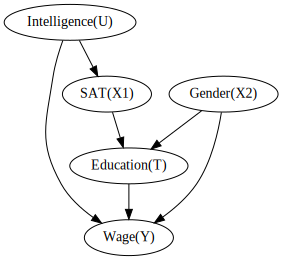

In [52]:
g3a = gr.Digraph()
g3a.edge("Education(T)", "Wage(Y)")
g3a.edge("Intelligence(U)", "Wage(Y)")
g3a.edge("Intelligence(U)", "SAT(X1)")
g3a.edge("Gender(X2)", "Wage(Y)")
g3a.edge("SAT(X1)", "Education(T)")
g3a.edge("Gender(X2)", "Education(T)")

g3a

### Using a Monte Carlo experiment with sample size N = 100

In [53]:
N = 100
 # use the right covariates in regression
Yexp,T,X = fn_generate_data(tau,N,100,50,corr,conf=True,flagX=1)
Xobs = X[:,:p0]
covars = np.concatenate([T,Xobs],axis = 1)
mod = sm.OLS(Yexp,covars)
res = mod.fit()
tauhat = res.params[0]
se_tauhat = res.HC1_se[0]
# n_values = n_values + [N]
# tauhats = tauhats + [tauhat]
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]
tauhat,se_tauhat

(4.252166093064552, 0.20309555021620965)

In [54]:
# np.linalg.inv(np.transpose(T)@T)@np.transpose(T)@Yexp
const = np.ones([N,1])
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
# res.summary()
res.params[0], res.HC1_se[0]

(-6.35879330072795, 33.988775160610075)

### Using a Monte Carlo experiment with sample size N = 1000

In [55]:
N = 1000
 # use the right covariates in regression
Yexp,T,X = fn_generate_data(tau,N,100,50,corr,conf=True,flagX=1)
Xobs = X[:,:p0]
covars = np.concatenate([T,Xobs],axis = 1)
mod = sm.OLS(Yexp,covars)
res = mod.fit()
tauhat = res.params[0]
se_tauhat = res.HC1_se[0]
# n_values = n_values + [N]
# tauhats = tauhats + [tauhat]
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]
tauhat,se_tauhat

(4.090699316547166, 0.04652868421083899)

In [56]:
# np.linalg.inv(np.transpose(T)@T)@np.transpose(T)@Yexp
const = np.ones([N,1])
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
# res.summary()
res.params[0], res.HC1_se[0]

(19.24316375240303, 7.006066420304278)

### Run R Monte Carlo iterations and compute bias, RMSE and size

In [57]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X = fn_generate_data(tau,N,100,50,corr,conf=True,flagX=1)
        Xobs = X[:,:p0]
        covars = np.concatenate([T,Xobs],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])}

100%|███████████████████████████████████████| 2000/2000 [01:19<00:00, 25.17it/s]


test null that $\tau = \tau_0$

In [58]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.0011359255683832579, RMSE=0.20666482763843222, size=0.051
N=1000: bias=0.0008919256366710131, RMSE=0.047848447667324434, size=0.0535


# Part 3
## (b) with selection bias

### Simulate a DGP

100%|█████████████████████████████████████████| 450/450 [00:09<00:00, 46.15it/s]


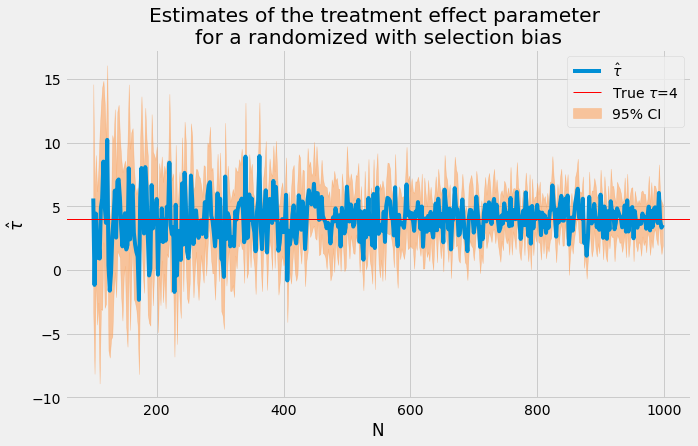

In [59]:
tau = 4
corr = .7
conf = True
p = 100
p0 = 50 # number of covariates used in the DGP
Nrange = range(100,1000,2) # loop over N values
flagX=2
(nvalues_3b,tauhats_3b,sehats_3b,lb,ub) = fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX)
caption_3b = """Estimates of the treatment effect parameter 
for a randomized with selection bias"""
fn_plot_with_ci(nvalues_3b,tauhats_3b,tau,lb,ub,caption_3b)

### Illustrate DAG with real-life situation

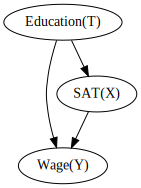

In [60]:
g3b = gr.Digraph()
g3b.edge("Education(T)", "Wage(Y)")
g3b.edge("Education(T)", "SAT(X)")
g3b.edge("SAT(X)", "Wage(Y)")

g3b

### Using a Monte Carlo experiment with sample size N = 100

In [61]:
N = 100
 # use the right covariates in regression
Yexp,T,X = fn_generate_data(tau,N,100,50,corr,conf=True,flagX=2)
Xobs1 = X[:,:np.int(p0/2)]
Xobs2 = X[:,-np.int(p0/2):]
covars = np.concatenate([T,Xobs1,Xobs2],axis = 1)
mod = sm.OLS(Yexp,covars)
res = mod.fit()
tauhat = res.params[0]
se_tauhat = res.HC1_se[0]
# n_values = n_values + [N]
# tauhats = tauhats + [tauhat]
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]
tauhat,se_tauhat

(-2.0424930640664023, 4.24469395588757)

In [62]:
# np.linalg.inv(np.transpose(T)@T)@np.transpose(T)@Yexp
const = np.ones([N,1])
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
# res.summary()
res.params[0], res.HC1_se[0]

(58.28011848702705, 46.032744458732246)

### Using a Monte Carlo experiment with sample size N = 1000

In [63]:
N = 100
 # use the right covariates in regression
Yexp,T,X = fn_generate_data(tau,N,100,50,corr,conf=True,flagX=2)
Xobs1 = X[:,:np.int(p0/2)]
Xobs2 = X[:,-np.int(p0/2):]
covars = np.concatenate([T,Xobs1,Xobs2],axis = 1)
mod = sm.OLS(Yexp,covars)
res = mod.fit()
tauhat = res.params[0]
se_tauhat = res.HC1_se[0]
# n_values = n_values + [N]
# tauhats = tauhats + [tauhat]
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]
tauhat,se_tauhat

(6.035197455637666, 6.010098197065498)

In [64]:
# np.linalg.inv(np.transpose(T)@T)@np.transpose(T)@Yexp
const = np.ones([N,1])
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
# res.summary()
res.params[0], res.HC1_se[0]

(37.52299496071686, 24.71679517357853)

### Run R Monte Carlo iterations and compute bias, RMSE and size

In [65]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X = fn_generate_data(tau,N,100,50,corr,conf=True,flagX=2)
        Xobs1 = X[:,:np.int(p0/2)]
        Xobs2 = X[:,-np.int(p0/2):]
        covars = np.concatenate([T,Xobs1,Xobs2],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])}

100%|███████████████████████████████████████| 2000/2000 [01:05<00:00, 30.66it/s]


test null that $\tau = \tau_0$

In [66]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.11740318080820328, RMSE=4.234083136983193, size=0.059
N=1000: bias=0.019958380749686765, RMSE=0.9511635038637105, size=0.049
